In [1]:
import io
import math
import numpy as np

#Read Zip File
import zipfile

#Read Images and XMLs
from PIL import Image, ImageFilter
import xml.etree.ElementTree as ET

#Visualize Results
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#Base Objects
samples = ['ground_truth','working']
data = {"img" : {samples[0] : {}, samples[1] : {}},
            'xml' : {samples[0] : {}, samples[1] : {}}}

#Load kaufland file
kaufland_files = zipfile.ZipFile('Kaufland_DataThon+2019_04_participants.zip','r')

In [3]:
def xml_to_dict(el):
    """
    Concerts XML to Dict. Note that the "object" tag is assigned to key "objects",
    which contains a list of all "object" tags. The "objects" element is placed on 
    the same level as annotation
    """
    my_dict = {}
    objects = []
  
    if(len(list(el))>0):
        my_dict_tmp = {}
        for el_tmp in el:
        
            if el_tmp.tag == "object":
                objects.append(xml_to_dict(el_tmp))
            else:
                my_dict_tmp.update(xml_to_dict(el_tmp))
    
        if len(objects) > 0:
            my_dict['objects'] = objects
    
        my_dict[el.tag] = my_dict_tmp
    else:
        my_dict[el.tag] = el.text
  
    return my_dict


for name in kaufland_files.namelist():
    for sample in samples:
        if name.startswith(sample):
            if name.endswith(".jpg"):
                data['img'][sample][name[name.rfind("_")+1:name.rfind(".")]] = Image.open(io.BytesIO(kaufland_files.read(name)))
            elif name.endswith(".xml"):
                data['xml'][sample][name[name.rfind("_")+1:name.rfind(".")]] = xml_to_dict(ET.fromstring(kaufland_files.read(name)))




Current ID: 160350


6

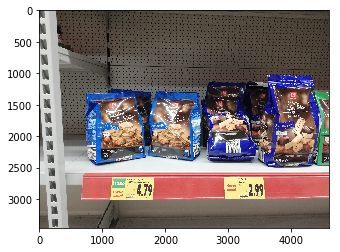

In [4]:
#Check File ID
my_id = list(data['img'][samples[0]].keys())[20]
print("Current ID:", my_id)

plt.imshow(data['img'][samples[0]][my_id])

#Check xml
len(data['xml'][samples[0]][my_id]['objects'])

# Extract Ranges of Labels

In [5]:
def get_label_fields(my_id):
    label_field = []
    for my_object in data['xml'][samples[0]][my_id]['objects']:
        if my_object['object']['name'].startswith("label"):

            ymax = int(my_object['object']['bndbox']['ymax'])
            ymin = int(my_object['object']['bndbox']['ymin'])

            if len(label_field) == 0:
                label_field.append([ymax, ymin])
            else:
                ok_flag = 0
                for value in label_field:
                    if value[0] >= ymax and value[1] <= ymin:
                        ok_flag = 1
                    elif value[0] < ymax and value[0] >= ymin and value[1] <= ymin:
                        value[0] = ymax
                        ok_flag = 1
                    elif value[0] >= ymax and value[1] <= ymax and value[1] > ymin:
                        value[1] = ymin
                        ok_flag = 1
                    elif value[0] < ymax and value[1] > ymin:
                        value[0] = ymax
                        value[1] = ymin
                        ok_flag = 1
                        
                if ok_flag == 0:
                    label_field.append([ymax, ymin])
    return label_field

    
#    print(my_object['object']['name'])
#    print(my_object['object']['bndbox'])

In [6]:
label_fields_all = {}
for my_id in list(data['img'][samples[0]].keys()):
    label_fields_all[my_id] = get_label_fields(my_id = my_id)

In [7]:
label_fields_all

{'160228': [[1809, 1486]],
 '160229': [[1808, 1478]],
 '160236': [[3059, 2630]],
 '160240': [[760, 174], [3192, 2838]],
 '160244': [[3135, 2727]],
 '160248': [[2819, 2402]],
 '160251': [[3031, 2680], [608, 24]],
 '160254': [[3152, 2802], [712, 151]],
 '160257': [[318, 1], [3056, 2625]],
 '160300': [[2948, 2529]],
 '160302': [[2963, 2548], [223, 1]],
 '160308': [[2923, 2500]],
 '160310': [[2901, 2428]],
 '160314': [[2718, 2268]],
 '160317': [[2862, 2430]],
 '160320': [[2989, 2477]],
 '160324': [[3100, 2612]],
 '160328': [[2936, 2548]],
 '160334': [[2430, 2042]],
 '160349': [[3000, 2628]],
 '160350': [[3011, 2639]],
 '160353': [[3046, 2646]],
 '160355': [[3050, 2639]],
 '160400': [[3121, 2663], [995, 582]],
 '160402': [[3125, 2737], [1036, 636]],
 '160406': [[3178, 2715]],
 '160410': [[3005, 2571]],
 '160412': [[2795, 2407], [628, 115]],
 '160416': [[2281, 1945], [2779, 2495]],
 '160420': [[3048, 2703]],
 '160428': [[2696, 2363]],
 '160431': [[2707, 2346]],
 '160435': [[2877, 2412]],
 '1

# Remove Object

In [8]:
def get_fill(positions, sample_length = 50, direction = "left",
                height = 3456, width = 4608):
    """
    Get positions for filler image
    """
    
    if (positions[0] - sample_length <= 0 and direction == "left") or \
            (positions[2] + sample_length >= width and direction == "right") or \
            (positions[1] - sample_length <= 0 and direction == "top") or \
            (positions[3] + sample_length >= height and direction == "bottom"):
        return False
    else:
        if direction == "left":
            fill = [max(positions[0]-sample_length,0), positions[1], positions[0]-1, positions[3]]
        elif direction == "right":
            fill = [positions[2]+1, positions[1], min(positions[2]+sample_length, width), positions[3]]
        elif direction == "top":
            fill = [positions[0], max(positions[1]-sample_length,0), positions[2], positions[1]-1]
        elif direction == "bottom":
            fill = [positions[0], positions[3]+1, positions[2], min(positions[3]+sample_length, height)]
        else:
            return False
        
        return fill

In [9]:
def check_object(fill, my_object):
    return not (fill[2] < my_object[0] or \
                    fill[0] >  my_object[2] or \
                    fill[3] < my_object[1] or \
                    fill[1] > my_object[3])

In [10]:
def check_image(my_id, if_label, fill, objects, label_fields, width = 4608):
    for my_object in objects:
        if my_object['object']['name'].startswith("label") == False:
            result = check_object(fill, [int(x) for x in my_object['object']['bndbox'].values()])
            
            if result == True:
                return True
    if if_label == False:
        for label_field in label_fields[my_id]  :
            result = check_object(fill, [0, label_field[1], width, label_field[0]])

            if result == True:
                return True
    else:
        for my_object in objects:
            if my_object['object']['name'].startswith("label") == True:
                result = check_object(fill, [int(x) for x in my_object['object']['bndbox'].values()])

                if result == True:
                    return True
    
    return False

# Remove Object

In [11]:
def remove_object(my_id, image, objects, object_idx, label_fields, force_product = False, 
                  depth = 0, test_pixels = [50, 60, 70]):
    #Get Object positions
    positions = [int(x) for x in objects[object_idx]['object']['bndbox'].values()]
    
    #Get object image
    image_crop_part = image.crop(positions)
    
    #Check if object is a label
    label_flag = objects[object_idx]['object']['name'].startswith("label")
    
    if force_product == True and label_flag == True:
        return False, positions
    
    if label_flag:
        directions = ["left", "right"]
    else:
        directions = ["left", "right", "top", "bottom"]
        
    #Check if any of the intervals is appropriate
    test_pixels.sort()
    test_pixels.reverse()
    
    #Iterate through all possible pixel lengths and directions
    result = True
    for pixel_length in test_pixels:
        for direction in directions:
            positions_crop = get_fill(positions, sample_length = pixel_length + 1, direction = direction)
            
            ##Skip if request is not possible
            if positions_crop == False:
                continue
            
            #Check if current filler can be used
            result = check_image(my_id, label_flag, positions_crop, objects, label_fields)

            #Exit if filler is appropriate
            if result == False:
                image_crop_fill = image.crop(positions_crop)
                break
        if result == False:
            break

    if result == True:
        return False, positions
    
    #Remove object from list
    objects.pop(object_idx)
    
    #Paste filler picture
    if direction in ['top', 'bottom']:
        fill_height = image_crop_fill.size[1]

        for i in range(0, math.ceil(image_crop_part.size[1]/fill_height)):
            if positions[1] + (i+1)*fill_height < positions[3]:
                image.paste(image_crop_fill, 
                                    [positions[0], 
                                         positions[1] + i*fill_height, 
                                         positions[2], 
                                         positions[1] + (i+1)*fill_height])
            else:
                image_crop_fill_tmp = image_crop_fill.crop((0, 
                                            0, 
                                            image_crop_fill.size[0], 
                                            image_crop_fill.size[1] - (-positions[3] + positions[1] + (i+1)*fill_height)))

                image.paste(image_crop_fill_tmp, 
                                    [positions[0], 
                                         positions[1] + i*fill_height, 
                                         positions[2], 
                                         positions[3]])
                
    else:
        fill_width = image_crop_fill.size[0]

        for i in range(0, math.ceil(image_crop_part.size[0]/fill_width)):
            if positions[0] + (i+1)*fill_width < positions[2]:
                image.paste(image_crop_fill, 
                                    [positions[0] + i*fill_width, 
                                         positions[1], 
                                         positions[0] + (i+1)*fill_width, 
                                         positions[3]])
            else:
                
                image_crop_fill_tmp = image_crop_fill.crop((0, 
                                            0, 
                                            image_crop_fill.size[0] - (-positions[2] + positions[0] + (i+1)*fill_width), 
                                            image_crop_fill.size[1]))

                image.paste(image_crop_fill_tmp, 
                                    [positions[0] + i*fill_width, 
                                         positions[1], 
                                         positions[2], 
                                         positions[3]])
    
    if depth == 0:
        counter = 0
        num_objects = len(objects)
        for test_object in range(num_objects):
            if test_object == len(objects):
                break
            my_object = objects[test_object]
            if my_object['object']['name'].startswith("label") == False:
                result = check_object(positions, [int(x) for x in my_object['object']['bndbox'].values()])

                if result == True:
                    result_tmp, _ = remove_object(my_id, image, objects, test_object, label_fields, depth = 1)


                    if result_tmp == True:
                        counter = counter + 1
                        
            if counter + test_object == num_objects - 1:
                break
                
    
    return True, positions
        

In [15]:
def gen_random_image(dataset, sample, force_product = False):
    image_idx = np.random.randint(0, high=len(dataset['img'][sample])-1)
    #Get Image ID
    my_id = list(dataset['img'][sample].keys())[image_idx]
    test_object = np.random.randint(0, high=len(dataset['xml'][sample][my_id]['objects'])-1)
    
    image = dataset['img'][sample][my_id].copy()
    objects = dataset['xml'][sample][my_id]['objects'].copy()
    
    result, positions = remove_object(my_id, image, objects, test_object, label_fields_all, force_product)

    return result, image, objects

# Generate Sample of one removed object

In [16]:
samples.append("remove_1")

In [17]:
data['img'][samples[2]] = {}
data['xml'][samples[2]] = {}

In [18]:
# Generate batches of new images
def generate_samples(gen_num, data, sample, new_sample, init_counter = False):
    if init_counter == False:
        counter = 0
    else:
        counter = init_counter
    
    while counter < gen_num:
        if counter < 0.3*gen_num:
            result, img, obj = gen_random_image(data, sample)
        else:
            result, img, obj = gen_random_image(data, sample, force_product = True)

        if result == True:
            counter = counter + 1
            
            data['img'][new_sample][new_sample+"_" + str(counter)] = img
            data['xml'][new_sample][new_sample+"_" + str(counter)] = {}
            data['xml'][new_sample][new_sample+"_" + str(counter)]['objects'] = obj
            
            if counter % 10 == 0:
                print("Images Generate:", counter)
            
        

In [35]:
generate_samples(400, data, samples[0], samples[2])

KeyboardInterrupt: 

In [ ]:
# Generate Sample of one removed object